In [16]:
import numpy as np
import pandas as pd
import re
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
with open("../data/slk_newscrawl_2016_1M/slk_newscrawl_2016_1M-sentences.txt", "r", encoding="utf-8") as f:
    # read lines and split at tab, keep only second column
    slk_df = pd.DataFrame(
        [line.strip().split("\t")[1] for line in f.readlines()], columns=["sentence"]
    )
    display(slk_df.head())

with open("../data/tur_news_2024_1M/tur_news_2024_1M-sentences.txt", "r", encoding="utf-8") as f:
    # read lines and split at tab, keep only second column
    tur_df = pd.DataFrame(
        [line.strip().split("\t")[1] for line in f.readlines()], columns=["sentence"]
    )
    display(tur_df.head())

,sentence
0,! 00:01 Nestrapnuj sa krcmovymi frajerinami a ...
1,"007iwb, platený diskuter, ktorý v každej debat..."
2,01:15 - tvoj mozog plný fekálií je schopný iba...
3,"01. apríl 2014, 07:18 Počet obetí zosuvu pôdy ..."
4,"01. apríl 2014, 14:33 Nora Mojsejová na slobode?"


,sentence
0,%0.1 çok düşük çok düşük bir büyüme.
1,"""01 Kasım 2024 tarihinden itibaren geçerli olm..."
2,"""02.04.2024 günü saat 12.47’de Beşiktaş ilçesi..."
3,"""02 Adana Yasin-Poyraz"" firmasının et dönerind..."
4,"‘ 0-4 yaş arası çocuklu annelere, ‘Anne Kart’ ..."


In [3]:
# clean and split sentences into words
def preprocess_sentences(df):
    # remove numbers and punctuation, convert to lowercase
    df["cleaned"] = (
        df["sentence"]
        .str.replace(r"[^\w\s]", "", regex=True)
        .str.replace(r"\d+", "", regex=True)
        .str.lower()
    )
    return df

In [4]:
display(preprocess_sentences(slk_df).head())
display(preprocess_sentences(tur_df).head())

,sentence,cleaned
0,! 00:01 Nestrapnuj sa krcmovymi frajerinami a ...,nestrapnuj sa krcmovymi frajerinami a impote...
1,"007iwb, platený diskuter, ktorý v každej debat...",iwb platený diskuter ktorý v každej debate o k...
2,01:15 - tvoj mozog plný fekálií je schopný iba...,tvoj mozog plný fekálií je schopný iba na pr...
3,"01. apríl 2014, 07:18 Počet obetí zosuvu pôdy ...",apríl počet obetí zosuvu pôdy v štáte washi...
4,"01. apríl 2014, 14:33 Nora Mojsejová na slobode?",apríl nora mojsejová na slobode


,sentence,cleaned
0,%0.1 çok düşük çok düşük bir büyüme.,çok düşük çok düşük bir büyüme
1,"""01 Kasım 2024 tarihinden itibaren geçerli olm...",kasım tarihinden itibaren geçerli olmak üzer...
2,"""02.04.2024 günü saat 12.47’de Beşiktaş ilçesi...",günü saat de beşiktaş ilçesi gayrettepe mahal...
3,"""02 Adana Yasin-Poyraz"" firmasının et dönerind...",adana yasinpoyraz firmasının et dönerinde der...
4,"‘ 0-4 yaş arası çocuklu annelere, ‘Anne Kart’ ...",yaş arası çocuklu annelere anne kart uygulam...


In [5]:
def build_statistics_df(df, lang):
    """
    Build a statistics dataframe for the given language dataframe.
    Returns a dataframe with the following statistics:
    - Language
    - Number of sentences
    - Number of words
    - Number of distinct words
    - Average sentence length (words)
    - Average sentence length (characters)
    """
    
    num_sentences = len(df)
    num_words = int(df["cleaned"].str.split().str.len().sum())
    num_distinct_words = len(set(" ".join(df["cleaned"]).split()))
    token_counts = [len(str(s).split()) for s in df["cleaned"]]
    char_counts = [len(str(s)) for s in df["cleaned"]]
    avg_sentence_length_chars = float(sum(char_counts) / num_sentences) if num_sentences else 0.0
    avg_sentence_length_words = float(sum(token_counts) / num_sentences) if num_sentences else 0.0

    stats = {
        "Language": lang,
        "Number of sentences": num_sentences,
        "Number of words": num_words,
        "Number of distinct words": num_distinct_words,
        "Average sentence length (words)": avg_sentence_length_words,
        "Average sentence length (characters)": avg_sentence_length_chars,
    }
    return pd.DataFrame([stats])


In [6]:
# build df with most frequent words, bigrams and trigrams
def build_frequent_ngrams_df(df, n=1, top_k=10, hapax_legomena=False):
    all_ngrams = []
    for sentence in df["sentence"]:
        tokens = sentence.split()
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    
    if hapax_legomena:
        ngram_counts = Counter(all_ngrams)
        all_ngrams = [ngram for ngram in all_ngrams if ngram_counts[ngram] == 1]

    ngram_counts = Counter(all_ngrams)
    most_common_ngrams = ngram_counts.most_common(top_k)

    ngram_list = [' '.join(ngram) for ngram, count in most_common_ngrams]
    counts = [count for ngram, count in most_common_ngrams]

    return pd.DataFrame({
        f'Top {top_k} {" ".join(["word"]*n)}s': ngram_list,
        'Count': counts
    })

In [ ]:
statistics_df = pd.DataFrame()
n_grams_dfs = pd.DataFrame()

for df, lang in [(slk_df, "Slovak"), (tur_df, "Turkish")]:
    statistics = build_statistics_df(df, lang)
    statistics_df = pd.concat([statistics_df, statistics], ignore_index=True)

    lang_ngams_df = pd.DataFrame()
    hapax_legomena = []

    # create n-grams for n = 1, 2, 3
    for n in [1, 2, 3]:
        frequent_ngrams_df = build_frequent_ngrams_df(df, n=n, top_k=100)
        frequent_ngrams_df.insert(0, 'Language', lang)
        lang_ngams_df = pd.concat([lang_ngams_df, frequent_ngrams_df.add_prefix(f"{n}gram_")], axis=1)

    hapax_legomena.append(build_frequent_ngrams_df(df, n=1, top_k=100, hapax_legomena=True))

    display(lang_ngams_df)
    lang_ngams_df.to_csv(f"../data/out/frequent_ngrams_{lang.lower()}.csv", index=False)

    display(hapax_legomena[:5])
    with open(f"../data/out/hapax_legomena_{lang.lower()}.txt", "w", encoding="utf-8") as f:
        for hapax in hapax_legomena[0]['Top 100 words']:
            f.write(f"{hapax}\n")

display(statistics_df)
statistics_df.to_csv("../data/out/statistics.csv", index=False)

,1gram_Language,1gram_Top 100 words,1gram_Count,2gram_Language,2gram_Top 100 word words,2gram_Count,3gram_Language,3gram_Top 100 word word words,3gram_Count
0,Slovak,v,343121,Slovak,nie je,15945,Slovak,Prečítajte si exkluzívne,14140
1,Slovak,a,330315,Slovak,Prečítajte si,14243,Slovak,si exkluzívne prognózy,14140
2,Slovak,na,325468,Slovak,si exkluzívne,14140,Slovak,exkluzívne prognózy TRENDU,14140
3,Slovak,sa,310920,Slovak,exkluzívne prognózy,14140,Slovak,príspevku do diskusie,10046
4,Slovak,je,161956,Slovak,prognózy TRENDU,14140,Slovak,pridanie príspevku do,10045
...,...,...,...,...,...,...,...,...,...
95,Slovak,Je,10665,Slovak,Zdieľaj na,2564,Slovak,júna (WEBNOVINY) -,644
96,Slovak,To,10645,Slovak,som si,2513,Slovak,"za to, že",642
97,Slovak,Slovensku,10428,Slovak,by sme,2497,Slovak,Na pridanie príspevku,604
98,Slovak,počas,10360,Slovak,aj s,2496,Slovak,by mala byť,604


[    Top 100 words  Count
 0      Nestrapnuj      1
 1     frajerinami      1
 2           01:03      1
 3         007iwb,      1
 4   neobhájitelné      1
 ..            ...    ...
 95    ohľaduplný,      1
 96  mafián-elegán      1
 97        suhlas!      1
 98        21rokov      1
 99         100LKR      1
 
 [100 rows x 2 columns]]

,1gram_Language,1gram_Top 100 words,1gram_Count,2gram_Language,2gram_Top 100 word words,2gram_Count,3gram_Language,3gram_Top 100 word word words,3gram_Count
0,Turkish,ve,339696,Turkish,hem de,8095,Turkish,sosyal medya hesabından,2631
1,Turkish,bir,222524,Turkish,bir şekilde,7953,Turkish,bir kez daha,2551
2,Turkish,bu,92751,Turkish,ifadelerini kullandı.,7697,Turkish,Cumhurbaşkanı Recep Tayyip,2451
3,Turkish,için,90696,Turkish,büyük bir,7081,Turkish,Büyükşehir Belediye Başkanı,1752
4,Turkish,ile,75331,Turkish,ya da,6731,Turkish,"Recep Tayyip Erdoğan,",1436
...,...,...,...,...,...,...,...,...,...
95,Turkish,5,9293,Turkish,şeklinde konuştu.,1576,Turkish,arasında yer alan,418
96,Turkish,konuştu.,9292,Turkish,en düşük,1574,Turkish,Cumhuriyet Halk Partisi,418
97,Turkish,olmak,9182,Turkish,olduğunu ve,1549,Turkish,yerine gelen sağlık,417
98,Turkish,saat,9161,Turkish,belli oldu.,1549,Turkish,Başkan Recep Tayyip,417


[     Top 100 words  Count
 0              "01      1
 1   fiyatlarımızda      1
 2      "02.04.2024      1
 3         12.47’de      1
 4              "02      1
 ..             ...    ...
 95            '1-2      1
 96            '12.      1
 97           ''12.      1
 98           Özel”      1
 99        danıştı!      1
 
 [100 rows x 2 columns]]

,Language,Number of sentences,Number of words,Number of distinct words,Average sentence length (words),Average sentence length (characters)
0,Slovak,1000000,15761954,586383,15.761954,103.397251
1,Turkish,1000000,13463224,405889,13.463224,102.775815


In [11]:
# Plotting Zipf's law
def plot_zipfs_law(df, lang):
    all_words = [word for sentence in df["cleaned"] for word in sentence.split()]
    word_counts = Counter(all_words)
    sorted_word_counts = sorted(word_counts.values(), reverse=True)
    ranks = range(1, len(sorted_word_counts) + 1)

    plt.loglog(ranks, sorted_word_counts, marker=".", label=lang)

In [12]:
# type or token frequency boxplots
def plot_sentence_length_boxplots(dfs, labels, measure="tokens"):
    """
    Plot boxplots of per-sentence measures for a list of dataframes.
    measure: "tokens" (default) for token counts per sentence,
             "types" for number of unique tokens per sentence.
    """
    measure = measure.lower()
    if measure not in {"tokens", "types", "token", "type"}:
        raise ValueError("measure must be 'tokens' or 'types'")

    if measure.startswith("type"):
        sentence_values = [df["cleaned"].apply(lambda x: len(set(x.split()))) for df in dfs]
        ylabel = "Unique tokens per sentence (types)"
        title = "Sentence Unique Token Distribution (types)"
    else:
        sentence_values = [df["cleaned"].apply(lambda x: len(x.split())) for df in dfs]
        ylabel = "Sentence length (tokens)"
        title = "Sentence Length Distribution (tokens)"

    plt.figure(figsize=(8, 6))
    plt.boxplot(sentence_values, labels=labels)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

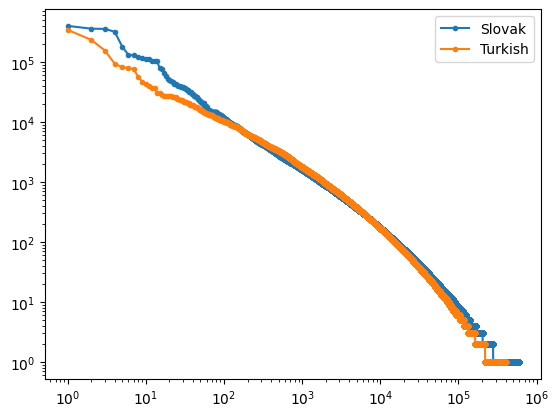

In [14]:
for df, lang in [(slk_df, "Slovak"), (tur_df, "Turkish")]:
    plot_zipfs_law(df, lang)
plt.legend()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44664\3982574944.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sentence_values, labels=labels)


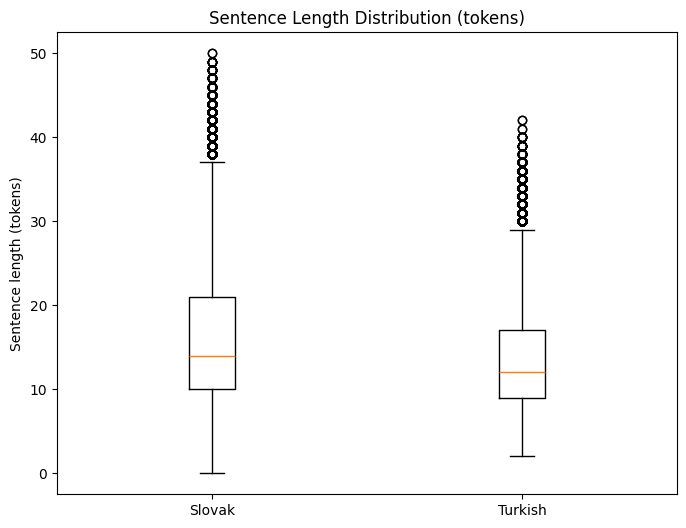

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44664\3982574944.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sentence_values, labels=labels)


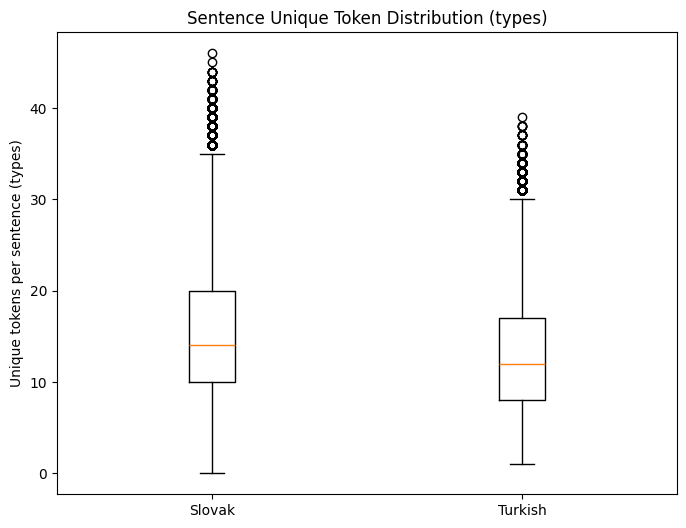

In [15]:
plot_sentence_length_boxplots([slk_df, tur_df], ["Slovak", "Turkish"])
plot_sentence_length_boxplots([slk_df, tur_df], ["Slovak", "Turkish"], measure="types")

In [17]:
# 10% shortest and longest sentences
def get_extreme_sentences(df, percentage=10):
    df = df.copy()
    df["sentence_length"] = df["cleaned"].apply(lambda x: len(x.split()))
    df = df.sort_values(by="sentence_length")
    n = int(len(df) * (percentage / 100))
    shortest = df.head(n)
    longest = df.tail(n)
    return shortest, longest

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44664\3982574944.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sentence_values, labels=labels)


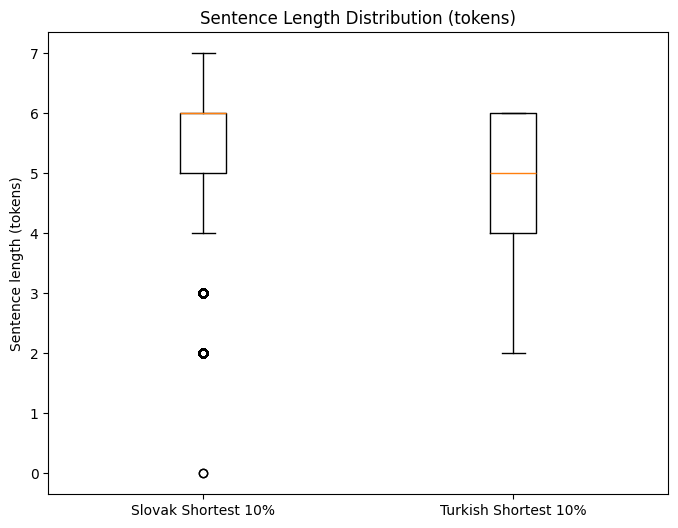

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44664\3982574944.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sentence_values, labels=labels)


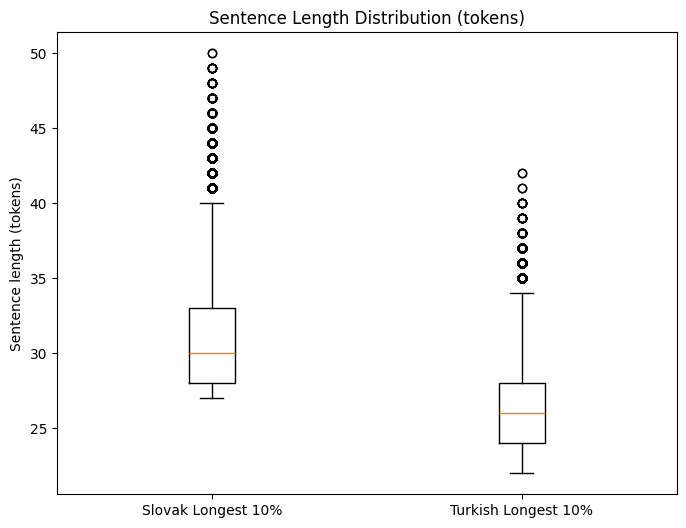

In [18]:
# boxplots for extreme sentences
slk_df_shortest, slk_df_longest = get_extreme_sentences(slk_df, percentage=10)
tur_df_shortest, tur_df_longest = get_extreme_sentences(tur_df, percentage=10)

plot_sentence_length_boxplots([slk_df_shortest, tur_df_shortest], ["Slovak Shortest 10%", "Turkish Shortest 10%"])
plot_sentence_length_boxplots([slk_df_longest, tur_df_longest], ["Slovak Longest 10%", "Turkish Longest 10%"])

In [23]:
# calculate median and mean and derivation for extreme sentences
def print_sentence_length_stats(df):
    token_counts = df["cleaned"].apply(lambda x: len(x.split()))
    print(f"Mean: {token_counts.mean():.3f}")
    print(f"Median: {token_counts.median()}")
    print(f"Standard Deviation: {token_counts.std():.3f}")

In [24]:
for df, lang in [
    (slk_df_shortest, "Slovak Shortest 10%"),
    (slk_df_longest, "Slovak Longest 10%"),
    (tur_df_shortest, "Turkish Shortest 10%"),
    (tur_df_longest, "Turkish Longest 10%"),
]:
    print(f"{lang}:")
    print_sentence_length_stats(df)
    print()

Slovak Shortest 10%:
Mean: 5.403
Median: 6.0
Standard Deviation: 1.059

Slovak Longest 10%:
Mean: 31.121
Median: 30.0
Standard Deviation: 3.380

Turkish Shortest 10%:
Mean: 4.905
Median: 5.0
Standard Deviation: 0.911

Turkish Longest 10%:
Mean: 26.208
Median: 26.0
Standard Deviation: 2.833



In [25]:
def count_exact(tokens, text):
    counts = {}
    for t in tokens:
        pattern = r"\b" + re.escape(t) + r"\b"
        counts[t] = len(re.findall(pattern, text))
    return counts

In [26]:
for s in slk_df["cleaned"].head():
    print(s)

  nestrapnuj sa krcmovymi frajerinami a impotenciou   no čo iné dokáže vyliezť z idiotského modrého boľševika  primitivizmus bez logiky ale to sme si už pri ich slabej mentálnej výbave zvykli
iwb platený diskuter ktorý v každej debate o kollárovi obhajuje neobhájitelné a tvrdí že čierne je biele a biele je čierne
  tvoj mozog plný fekálií je schopný iba na primitívne opakovanie cudzích textov a písanie pod cudzími nickmi písať k téme nemáš dostatočnú mentálnu výbavu a na civilizovanú debatu základné morálne zásady ako je česť a férovosť
 apríl   počet obetí zosuvu pôdy v štáte washington stúpol na wsghington  dvadsaťdva ľudí je naďalej nezvestných po mohutnom zosuve pôdy ku ktorému došlo  marca neďaleko mesta oso v americkom štáte washington
 apríl   nora mojsejová na slobode


In [27]:
# Conjunction lists
slovak_conjunctions = ["a", "alebo", "ani", "či"]
turkish_conjunctions = ["ve", "veya"]
turkish_bigram = r"\bya\s+da\b"

# Initialize counters
slk_counts = {c: 0 for c in slovak_conjunctions}
tur_counts = {c: 0 for c in turkish_conjunctions}
tur_counts["ya da"] = 0  # also track bigram

# Accumulate Slovak counts
for s in slk_df["cleaned"]:
    c = count_exact(slovak_conjunctions, s)
    for key, value in c.items():
        slk_counts[key] += value

# Accumulate Turkish counts
for t in tur_df["cleaned"]:
    c = count_exact(turkish_conjunctions, t)
    for key, value in c.items():
        tur_counts[key] += value
    tur_counts["ya da"] += len(re.findall(turkish_bigram, t))

print("Slovak counts:", slk_counts)
print("Turkish counts:", tur_counts)


Slovak counts: {'a': 354081, 'alebo': 26743, 'ani': 24190, 'či': 23663}
Turkish counts: {'ve': 341422, 'veya': 11166, 'ya da': 6942}
